In [2]:
%%capture
!pip install watermark

In [3]:
%load_ext watermark
%watermark -a "Ankush SIngal" -u -d -p numpy,scipy,matplotlib,tensorflow

Author: Ankush SIngal

Last updated: 2023-05-06

numpy     : 1.22.4
scipy     : 1.10.1
matplotlib: 3.7.1
tensorflow: 2.12.0



#Building a linear regression model

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)

ds_joint = tf.data.Dataset.zip((ds_x, ds_y))

for example in ds_joint:
     print('  x:', example[0].numpy(),
          '  y:', example[1].numpy())

  x: [0.19064724 0.07562995 0.09263933]   y: 0
  x: [0.6362802  0.55635905 0.50437737]   y: 1
  x: [9.2690468e-02 8.4398067e-01 5.4562092e-04]   y: 2
  x: [0.7142608  0.3347931  0.08579576]   y: 3


#Shuffle, batch, and repeat
As was mentioned in Chapter 2, Training Simple Machine Learning Algorithms for Classification, to train an NN model using stochastic gradient descent optimization, it is important to feed training data as randomly shuffled batches. You have already seen how to create batches by calling the .batch() method of a dataset object. Now, in addition to creating batches, you will see how to shuffle and reiterate over the datasets. We will continue working with the previous ds_joint dataset.

In [10]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))

for example in ds:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [9.2690468e-02 8.4398067e-01 5.4562092e-04]   y:  2
  x:  [0.6362802  0.55635905 0.50437737]   y:  1
  x:  [0.19064724 0.07562995 0.09263933]   y:  0
  x:  [0.7142608  0.3347931  0.08579576]   y:  3


In [11]:
ds = ds_joint.batch(batch_size=3,
                    drop_remainder=False)

batch_x, batch_y = next(iter(ds))

print('Batch-x: \n', batch_x.numpy())

print('Batch-y:   ', batch_y.numpy())

Batch-x: 
 [[1.9064724e-01 7.5629950e-02 9.2639327e-02]
 [6.3628018e-01 5.5635905e-01 5.0437737e-01]
 [9.2690468e-02 8.4398067e-01 5.4562092e-04]]
Batch-y:    [0 1 2]


In [12]:
ds = ds_joint.batch(3).repeat(count=2)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


In [15]:
## Order 1: shuffle -> batch -> repeat
tf.random.set_seed(1)
ds = ds_joint.shuffle(4).batch(2).repeat(3)
for i,(batch_x, batch_y) in enumerate(ds):
  print(i, batch_x.shape, batch_y.numpy())


0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]


In [16]:
## Order 2: batch -> shuffle -> repeat
tf.random.set_seed(1)
ds = ds_joint.batch(2).shuffle(4).repeat(3)
for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())


0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


While the first code example (shuffle, batch, repeat) appears to have shuffled the dataset as expected, we can see that in the second case (batch, shuffle, repeat), the elements within a batch were not shuffled at all. We can observe this lack of shuffling by taking a closer look at the tensor containing the target values,

## Creating a dataset from files on your local storage disk

In [17]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
     

Mounted at /content/gdrive/


In [18]:
import pathlib

imgdir_path = pathlib.Path('/content/drive/MyDrive/cat_dog_images')

file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

print(file_list)


['/content/drive/MyDrive/cat_dog_images/cat-01.jpg', '/content/drive/MyDrive/cat_dog_images/cat-02.jpg', '/content/drive/MyDrive/cat_dog_images/cat-03.jpg', '/content/drive/MyDrive/cat_dog_images/dog-01.jpg', '/content/drive/MyDrive/cat_dog_images/dog-02.jpg', '/content/drive/MyDrive/cat_dog_images/dog-03.jpg']


Image shape:  (900, 1200, 3)
Image shape:  (900, 1200, 3)
Image shape:  (900, 742, 3)
Image shape:  (800, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (900, 1200, 3)


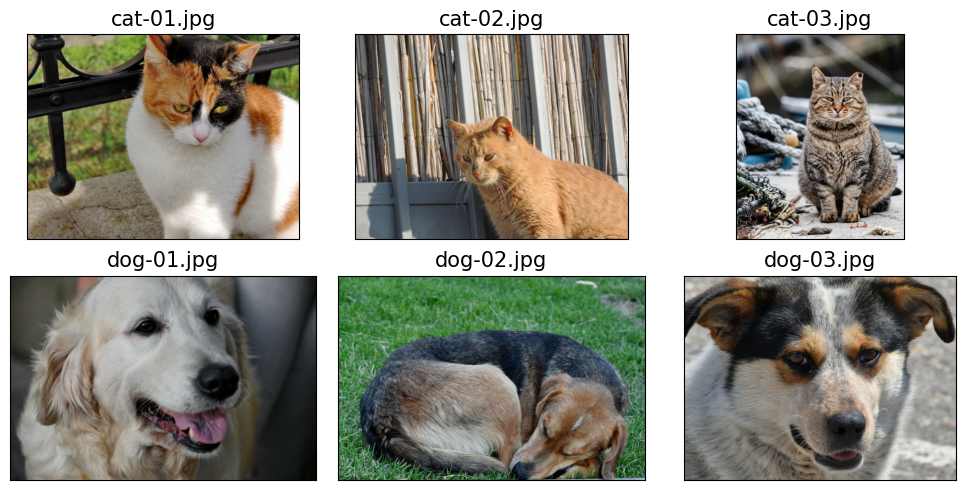

In [19]:
import matplotlib.pyplot as plt
import os


fig = plt.figure(figsize=(10, 5))
for i,file in enumerate(file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
# plt.savefig('ch13-catdot-examples.pdf')
plt.tight_layout()
plt.show()

In [20]:
labels = [1 if 'dog' in os.path.basename(file) else 0
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [21]:
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'/content/drive/MyDrive/cat_dog_images/cat-01.jpg' 0
b'/content/drive/MyDrive/cat_dog_images/cat-02.jpg' 0
b'/content/drive/MyDrive/cat_dog_images/cat-03.jpg' 0
b'/content/drive/MyDrive/cat_dog_images/dog-01.jpg' 1
b'/content/drive/MyDrive/cat_dog_images/dog-02.jpg' 1
b'/content/drive/MyDrive/cat_dog_images/dog-03.jpg' 1


(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 1
(80, 120, 3) 1
(80, 120, 3) 1


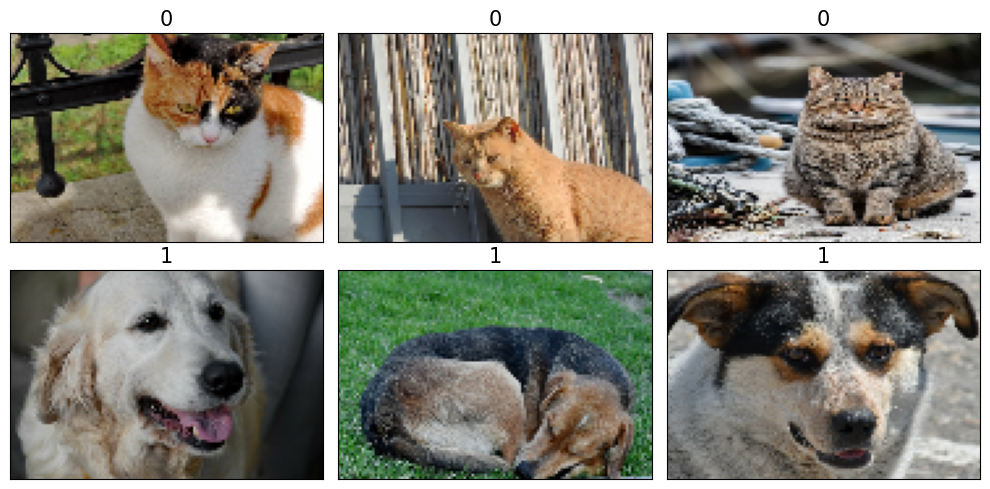

In [22]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0

    return image, label

img_width, img_height = 120, 80

ds_images_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(ds_images_labels):
    print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
#plt.savefig('ch13-catdog-dataset.pdf')
plt.show()

## Fetching available datasets from the tensorflow_datasets library

In [23]:
! pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders()))
print(tfds.list_builders()[:5])

1139
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


In [31]:
mnist, mnist_info = tfds.load('mnist', with_info=True,
                              shuffle_files=False)

print(mnist_info)

print(mnist.keys())

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1.incompleteO05119',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
     

(10, 28, 28, 1) tf.Tensor([4 1 0 7 8 1 2 7 1 6], shape=(10,), dtype=int64)


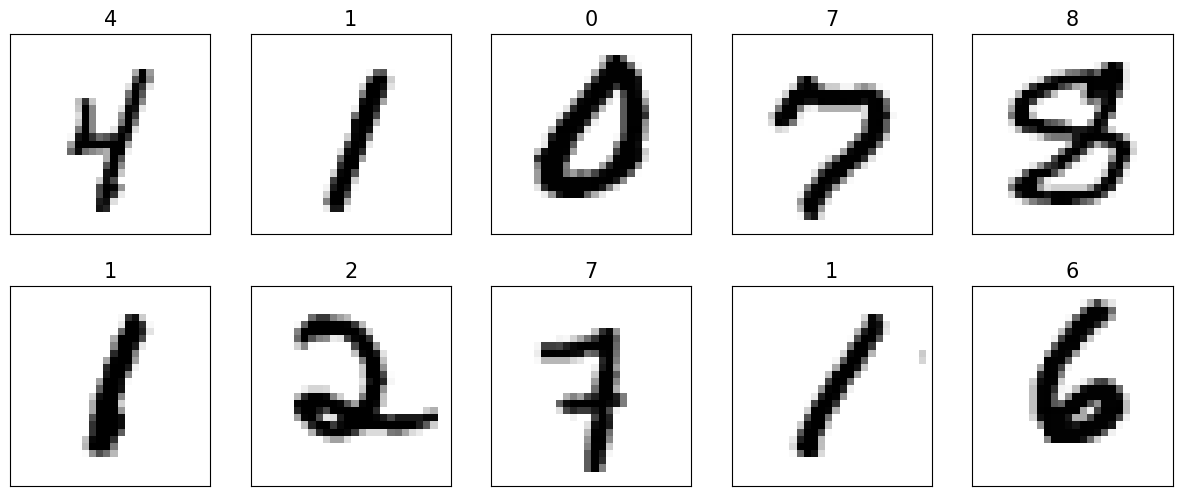

In [32]:
ds_train = mnist['train']

assert isinstance(ds_train, tf.data.Dataset)

ds_train = ds_train.map(lambda item: 
     (item['image'], item['label']))

ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

fig = plt.figure(figsize=(15, 6))
for i,(image,label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap='gray_r')
    ax.set_title('{}'.format(label), size=15)
    
plt.show()